<a href="https://colab.research.google.com/github/adijams01/Shoes_CNN/blob/main/Sneakers_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Becoming one with Data

In [14]:
import zipfile

# Unzip the downloaded file from github or kaggle "https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged?resource=download"
zip_ref = zipfile.ZipFile("Sneakers_CNN.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [15]:
import os

# Walk through  directory and list number of files
print("TRAIN---")
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("TEST---")
for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

TRAIN---
There are 3 directories and 0 images in 'train'.
There are 0 directories and 237 images in 'train/nike'.
There are 0 directories and 237 images in 'train/converse'.
There are 0 directories and 237 images in 'train/adidas'.
TEST---
There are 3 directories and 0 images in 'test'.
There are 0 directories and 38 images in 'test/nike'.
There are 0 directories and 38 images in 'test/converse'.
There are 0 directories and 38 images in 'test/adidas'.


In [16]:
train_dir="train/"
test_dir="test/"

In [17]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['adidas' 'converse' 'nike']


In [18]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (240, 240, 3)


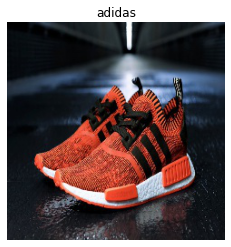

In [19]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name
     

## Data Preprocessing

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


### Plot loss curves function

In [27]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Baseline model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Activation

In [62]:
# Create our model (baseline model)
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1 = model_1.fit(train_data, # now 3 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
23/23 [==============================] - 5s 141ms/step - loss: 1.0946 - accuracy: 0.3882 - val_loss: 1.0816 - val_accuracy: 0.5351
Epoch 2/5
23/23 [==============================] - 2s 87ms/step - loss: 1.0472 - accuracy: 0.4768 - val_loss: 1.0227 - val_accuracy: 0.5175
Epoch 3/5
23/23 [==============================] - 2s 87ms/step - loss: 0.9553 - accuracy: 0.5457 - val_loss: 1.0321 - val_accuracy: 0.4649
Epoch 4/5
23/23 [==============================] - 2s 82ms/step - loss: 0.7806 - accuracy: 0.6793 - val_loss: 1.1358 - val_accuracy: 0.4912
Epoch 5/5
23/23 [==============================] - 2s 81ms/step - loss: 0.5978 - accuracy: 0.7567 - val_loss: 1.1283 - val_accuracy: 0.5351


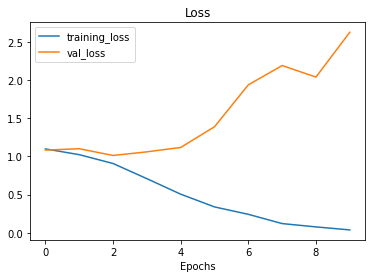

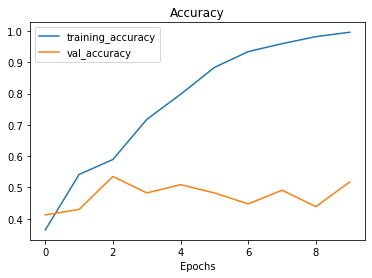

In [61]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_1)

## Data augmentation

In [57]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 711 images belonging to 3 classes.


In [58]:
# Clone the model (use the same architecture)
model_2 = tf.keras.models.clone_model(model_1)

# Compile the cloned model (same setup as used for model_10)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
23/23 [==============================] - 10s 375ms/step - loss: 1.2278 - accuracy: 0.3122 - val_loss: 1.0944 - val_accuracy: 0.3246
Epoch 2/5
23/23 [==============================] - 9s 388ms/step - loss: 1.0950 - accuracy: 0.3769 - val_loss: 1.0808 - val_accuracy: 0.3509
Epoch 3/5
23/23 [==============================] - 9s 368ms/step - loss: 1.0971 - accuracy: 0.3952 - val_loss: 1.0867 - val_accuracy: 0.4298
Epoch 4/5
23/23 [==============================] - 8s 348ms/step - loss: 1.0866 - accuracy: 0.3938 - val_loss: 1.0674 - val_accuracy: 0.3421
Epoch 5/5
23/23 [==============================] - 9s 404ms/step - loss: 1.0851 - accuracy: 0.3896 - val_loss: 1.0730 - val_accuracy: 0.3947


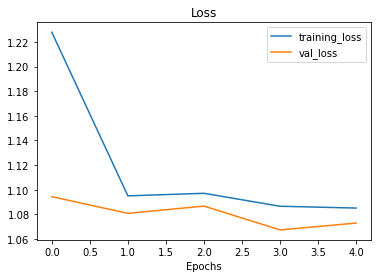

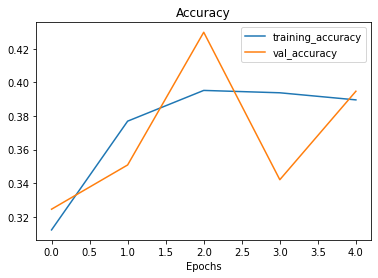

In [59]:
# Check out our model's performance with augmented data
plot_loss_curves(history_2)

In [52]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model_1)

# Compile the cloned model (same setup as used for model_10)
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
23/23 [==============================] - 11s 395ms/step - loss: 308.9445 - accuracy: 0.3319 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 2/5
23/23 [==============================] - 9s 381ms/step - loss: 1.1020 - accuracy: 0.3305 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 3/5
23/23 [==============================] - 8s 340ms/step - loss: 1.1036 - accuracy: 0.3150 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 4/5
23/23 [==============================] - 9s 375ms/step - loss: 1.1017 - accuracy: 0.3277 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 5/5
23/23 [==============================] - 9s 382ms/step - loss: 1.1047 - accuracy: 0.3136 - val_loss: 1.1029 - val_accuracy: 0.3333


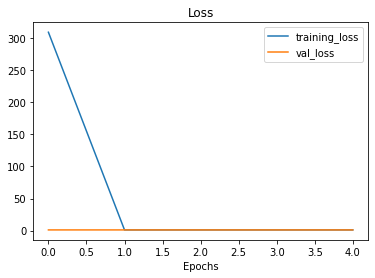

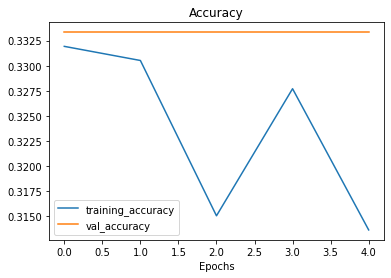

In [53]:
# Check out our model's performance with augmented data
plot_loss_curves(history_3)

## model summarys

In [63]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_41 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_43 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

In [64]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_33 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_35 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

In [65]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

### Evaluations

In [70]:
# Evaluate on the test data
model_1.evaluate(test_data)

4/4 [==============================] - 0s 57ms/step - loss: 1.1283 - accuracy: 0.5351


[1.1282538175582886, 0.5350877046585083]

In [68]:
# Evaluate on the test data
model_2.evaluate(test_data)

4/4 [==============================] - 0s 76ms/step - loss: 1.0730 - accuracy: 0.3947


[1.072959542274475, 0.3947368562221527]

In [69]:
# Evaluate on the test data
model_3.evaluate(test_data)

4/4 [==============================] - 0s 58ms/step - loss: 1.1029 - accuracy: 0.3333


[1.1029237508773804, 0.3333333432674408]

## Predictions
making predictions on model_1 as it is the best model still now.
Generally models after augmentation give more better results (First time it gave but than it is getting low validation_accuracy)

In [78]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [79]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
     

In [80]:
# What classes has our model been trained on?
class_names

array(['adidas', 'converse', 'nike'], dtype='<U8')

1/1 [==============================] - 0s 19ms/step


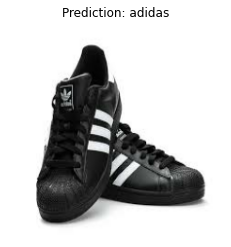

In [89]:
# Make a prediction using model_1
pred_and_plot(model=model_1, 
              filename="adidas_example.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 21ms/step


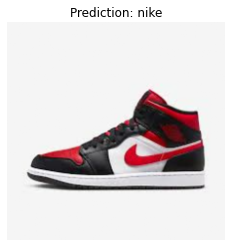

In [90]:
# Make a prediction using model_1
pred_and_plot(model=model_1, 
              filename="nike_example.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 23ms/step


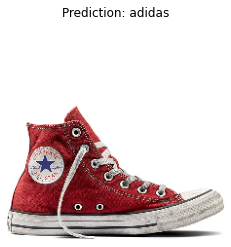

In [91]:
# Make a prediction using model_1
pred_and_plot(model=model_1, 
              filename="converse_example.jpg", 
              class_names=class_names)

## Conclusion
model_1's accuracy is 53.51..%,
it is predicting correctly for nike and adidas but for converse its failing
it can be further improved with help of transfer learning.